# Load libraries and set device up

In [1]:
import seaborn           as sns
import numpy             as np
import matplotlib.pyplot as plt
import torch
import json
import os

import libraries.model   as clm
import libraries.dataset as cld

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set_theme()

# Define parameters

In [2]:
target = 'bandgap'
folder = 'MP-bandgap'

r_folder = f'models/{folder}'
t_folder = f'targets/{folder}'

# Generate or load graph database for training

Reference dataset

In [3]:
files_names = {
    'r_dataset_std_name':      f'{r_folder}/train_dataset_std.pt',
    'r_std_parameters_name':   f'{r_folder}/standardized_parameters.json',
    'r_uncertainty_data_name': f'{r_folder}/uncertainty_data.json',
    'model_name':              f'{r_folder}/model.pt',
    'dt_param_name':           f'{r_folder}/dataset_parameters.json',
    't_dataset_name':          f'{t_folder}/dataset.pt'
}
cld.save_json(files_names, f'{t_folder}/files_names.json')

In [4]:
# Load the standardized dataset, with corresponding labels and parameters
r_dataset_std = torch.load(files_names['r_dataset_std_name'], weights_only=False)

# Load uncertainty data
r_uncertainty_data = cld.load_json(files_names['r_uncertainty_data_name'])

# Load std parameters data
r_std_parameters = cld.load_json(files_names['r_std_parameters_name'])

# Load dataset parameters data
r_dataset_parameters = cld.load_json(files_names['dt_param_name'])

# Defining target factor
target_factor = r_std_parameters['target_std'] / r_std_parameters['scale']

Prediciton dataset

In [10]:
if not os.path.exists(files_names['t_dataset_name']):
    # Generate data
    cld.generate_dataset(t_folder,
                         targets=['bandgap'],
                         data_folder=t_folder)

# Load the standardized dataset, with corresponding labels and parameters
t_dataset = torch.load(files_names['t_dataset_name'], weights_only=False)

# Determine the index for the desired property
target_idx = [idx for idx, t in enumerate(r_dataset_parameters['target']) if t == target][0]

# Select the target we want
for data in t_dataset:
    data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

# Select the target we want
ground_truths = np.array([data.y.item() for data in t_dataset])

# Standardize the dataset with
t_dataset_std = cld.standardize_dataset_from_keys(t_dataset, r_std_parameters)
del t_dataset

# Load model and make predictions

In [6]:
model = clm.load_model(r_dataset_std[0].num_node_features, 0, device, model_name=files_names['model_name'], purpose='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [40]:
t_dataset_std[0].x

tensor([[ 33.2790,  34.9180, -51.0563, -45.4709],
        [ 33.2790,  34.9180, -51.0563, -45.4709],
        [-22.8875, -25.4537, -50.1451, -47.9552],
        [ 11.1595,  14.2191, -24.3298, -27.1702],
        [-16.5813, -16.8292,  24.5676,  20.1964],
        [-16.5813, -16.8292,  24.5676,  20.1964],
        [-16.5813, -16.8292,  24.5676,  20.1964],
        [-14.4935, -15.1043,  40.9679,  51.6637]])

In [41]:
r_dataset_std[90].x

tensor([[ 36.9592,  40.0927, -31.3151, -36.6104],
        [ 36.9592,  40.0927, -31.3151, -36.6104],
        [ 36.9592,  40.0927, -31.3151, -36.6104],
        [ 36.9592,  40.0927, -31.3151, -36.6104],
        [ 63.6878,  62.5165,  -0.9441,   7.8579],
        [ 63.6878,  62.5165,  -0.9441,   7.8579],
        [ 63.6878,  62.5165,  -0.9441,   7.8579],
        [ 63.6878,  62.5165,  -0.9441,   7.8579],
        [-14.4935, -15.1043,  40.9679,  51.6637],
        [-14.4935, -15.1043,  40.9679,  51.6637],
        [-14.4935, -15.1043,  40.9679,  51.6637],
        [-14.4935, -15.1043,  40.9679,  51.6637],
        [-14.4935, -15.1043,  40.9679,  51.6637],
        [-14.4935, -15.1043,  40.9679,  51.6637],
        [-14.4935, -15.1043,  40.9679,  51.6637],
        [-14.4935, -15.1043,  40.9679,  51.6637],
        [-14.4935, -15.1043,  40.9679,  51.6637],
        [-14.4935, -15.1043,  40.9679,  51.6637],
        [-14.4935, -15.1043,  40.9679,  51.6637],
        [-14.4935, -15.1043,  40.9679,  51.6637],


In [24]:
for i in range(len(t_dataset_std)):
    d = t_dataset_std[i]
    if d.label == 'CaAl2SiO6-C2':
        print(i, d)

90 Data(x=[20, 4], edge_index=[2, 828], edge_attr=[828], y=[1], label='CaAl2SiO6-C2')


In [48]:
t_dataset_std[90].edge_attr

tensor([  3.5067,   3.5067,  -1.3868,  -1.3868,   1.8656,   1.8656,  -5.8715,
          6.0775,   3.9510,  -5.2001,  -5.8715,   6.0775,  -5.2001,   3.9510,
          2.9639,   1.7131,   1.7131,  -4.6633,  -5.6374,  -5.6374,   3.9333,
          3.9333,  -6.4028,  -3.7304,   5.3821,   1.0289,  -3.7304,  -6.4028,
          1.0289,   5.3821,  -0.3578,   1.3984,  -9.5950,  -1.3861,  -4.4812,
          5.8775,   1.6535,   1.0791,  -9.2780,   2.5435,   1.4320,  -0.3578,
         -9.5950,   1.3984,  -1.3861,  -4.4812,   5.8775,   1.6535,  -9.2780,
          1.0791,   1.4320,   2.5435,  -0.8466,   1.2746,   4.9708,   2.3981,
         -2.5189,   5.6377,  -9.2569,  -4.1110,   3.7536,  -1.6542,  -8.7812,
         -0.5714,   1.2746,  -0.8466,  -2.5189,   2.3981,   4.9708,   5.6377,
         -4.1110,  -9.2569,   3.7536,  -8.7812,  -1.6542,  -0.5714,   3.5067,
          3.5067,  -3.6683,  -6.2526,   0.9669,   5.3722,  -3.6683,  -6.2526,
          0.9669,   5.3722,  -5.6379,  -5.6379,   3.9337,   3.93

In [43]:
for i in range(len(r_dataset_std)):
    d = r_dataset_std[i]
    if d.label == 'CaAl2SiO6-C2':
        print(i, d)

15794 Data(x=[20, 4], edge_index=[2, 828], edge_attr=[828], y=[1], label='CaAl2SiO6-C2')


In [47]:
r_dataset_std[15794].edge_attr

tensor([  3.5067,   3.5067,  -1.3868,  -1.3868,   1.8656,   1.8656,  -5.8715,
          6.0775,   3.9510,  -5.2001,  -5.8715,   6.0775,  -5.2001,   3.9510,
          2.9639,   1.7131,   1.7131,  -4.6633,  -5.6374,  -5.6374,   3.9333,
          3.9333,  -6.4028,  -3.7304,   5.3821,   1.0289,  -3.7304,  -6.4028,
          1.0289,   5.3821,  -0.3578,   1.3984,  -9.5950,  -1.3861,  -4.4812,
          5.8775,   1.6535,   1.0791,  -9.2780,   2.5435,   1.4320,  -0.3578,
         -9.5950,   1.3984,  -1.3861,  -4.4812,   5.8775,   1.6535,  -9.2780,
          1.0791,   1.4320,   2.5435,  -0.8466,   1.2746,   4.9708,   2.3981,
         -2.5189,   5.6377,  -9.2569,  -4.1110,   3.7536,  -1.6542,  -8.7812,
         -0.5714,   1.2746,  -0.8466,  -2.5189,   2.3981,   4.9708,   5.6377,
         -4.1110,  -9.2569,   3.7536,  -8.7812,  -1.6542,  -0.5714,   3.5067,
          3.5067,  -3.6683,  -6.2526,   0.9669,   5.3722,  -3.6683,  -6.2526,
          0.9669,   5.3722,  -5.6379,  -5.6379,   3.9337,   3.93

In [7]:
# Compute predictions
predictions, uncertainties, are_interpolated = clm.make_predictions(r_dataset_std,
                                                                    t_dataset_std,
                                                                    model, r_std_parameters, r_uncertainty_data)

# Plot predictions

uncertainties = np.zeros(len(uncertainties))

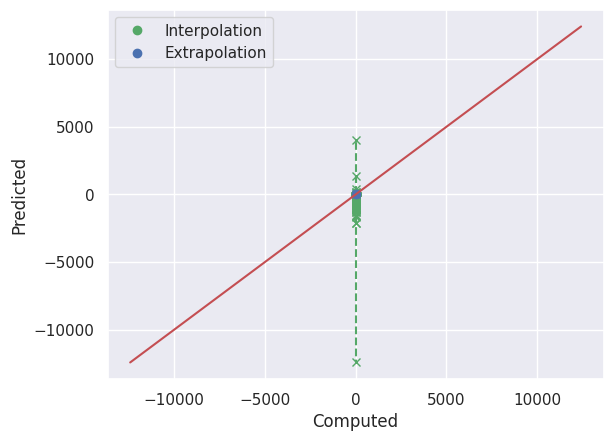

In [11]:
# Extract and plot interpolation data
xpred_interp = ground_truths[are_interpolated]
ypred_interp = predictions[are_interpolated]
yerr_interp = uncertainties[are_interpolated]

plt.plot(xpred_interp, ypred_interp, 'og', label='Interpolation')  # Predictions
plt.plot(xpred_interp, ypred_interp + yerr_interp, 'xg')           # Corrected values
for x, y, err in zip(xpred_interp, ypred_interp, yerr_interp):
    plt.plot([x, x], [y, y + err], 'g--')  # Vertical line

# Extract and plot extrapolation data
xpred_extra = ground_truths[~are_interpolated]
ypred_extra = predictions[~are_interpolated]
yerr_extra = uncertainties[~are_interpolated]

plt.plot(xpred_extra, ypred_extra, 'ob', label='Extrapolation')    # Predictions
plt.plot(xpred_extra, ypred_extra + yerr_extra, 'xb')             # Corrected values
for x, y, err in zip(xpred_extra, ypred_extra, yerr_extra):
    plt.plot([x, x], [y, y + err], 'b--')  # Vertical line

# Add identity line and labels
_min_, _max_ = cld.get_min_max(
    ground_truths + np.abs(uncertainties),
    ground_truths - np.abs(uncertainties),
    predictions
)
plt.plot([_min_, _max_], [_min_, _max_], '-r')  # Identity line
plt.xlabel('Computed')
plt.ylabel('Predicted')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-prediction-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()

In [ ]:
gt_uncertainties   = np.abs(ground_truths - predictions)
pred_uncertainties = np.abs(uncertainties)

xpred = gt_uncertainties[are_interpolated]
ypred = pred_uncertainties[are_interpolated]
plt.plot(xpred, ypred, 'og', label='Interpolation')

xpred = gt_uncertainties[~are_interpolated]
ypred = pred_uncertainties[~are_interpolated]
plt.plot(xpred, ypred, 'ob', label='Extrapolation')

_min_, _max_ = cld.get_min_max([gt_uncertainties, pred_uncertainties])
plt.plot([_min_, _max_], [_min_, _max_], '-r')
plt.xlabel(r'Computed uncert')
plt.ylabel(r'Predicted uncert')
plt.legend(loc='best')
plt.savefig(f'{t_folder}/UQ-values-comparison.pdf', dpi=50, bbox_inches='tight')
plt.show()